# Plot spindle current versus temperature

We want to visualize the relationship between the current and the temperature of the spindle. In order to do that, we want to take averages by given time slots. 

In [54]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

current_folder = os.getcwd()
print(current_folder)

from parse.loadCsvSignal import loadCsvSignal

from plot.plotSegments import plotSegments

from signalProcessing.computeSlotsAverage import computeSlotsAverage
from signalProcessing.splitSignal import splitSignal
from signalProcessing.removeSegmentsBeginning import removeSegmentsBeginning

from temperatureCorrection.getTemperatureCorrectionData import getTemperatureCorrectionData
from temperatureCorrection.findTemperatureOffset import findTemperatureOffset
from temperatureCorrection.showTempCorrectionPlots import showTempCorrectionPlots
from temperatureCorrection import temperatureCorrection

from utils.detectConstantSegments import detectConstantSegments
from utils.getOperationsStart import getOperationsStart
from utils.customPolyFit import getPolyRegression, evalPolyReg
from utils.polyFit import getPolyFits, getErrors, getRelativeErrors, evalModels

/Users/opatiny/git/opatiny/predictiveMaintenance/src/notebooks


## Load some data

   

In [55]:
folderPath = "../../data/Mecatis/05_02_25/"

temperature = "lrSigSpindleTemp.csv"
currentSlots = "stSigAxCurrentS.csv"

tempPath = current_folder + "/" + folderPath + temperature
currentPath = current_folder + "/" + folderPath + currentSlots


temperatureData = loadCsvSignal(tempPath, normalize=True, debug=True)
currentData = loadCsvSignal(currentPath, normalize=True, debug=True)


getFormattedSignalData - Number of points to sort:  4272
removeDuplicates - Number duplicates: 1038
getFormattedSignalData - Number of points to sort:  2065466
removeDuplicates - Number duplicates: 0


### Plot the data

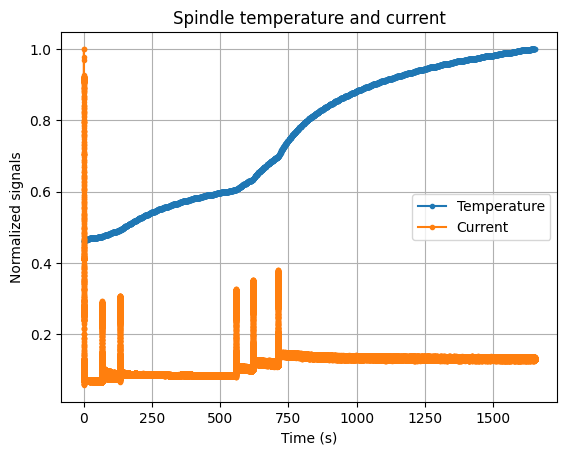

In [56]:
plt.plot(
    temperatureData.loc[:, "timeSeconds"], temperatureData.loc[:, "value"], "o-", markersize=3)
plt.plot(
    currentData.loc[:, "timeSeconds"], currentData.loc[:, "value"], "o-", markersize=3)
plt.xlabel("Time (s)")
# plt.ylabel("Temperature (°C) / Current (A)")
plt.ylabel("Normalized signals")
plt.legend(["Temperature", "Current"])

plt.title("Spindle temperature and current")
plt.grid()

plt.show()

### Plot the data averaged by slots

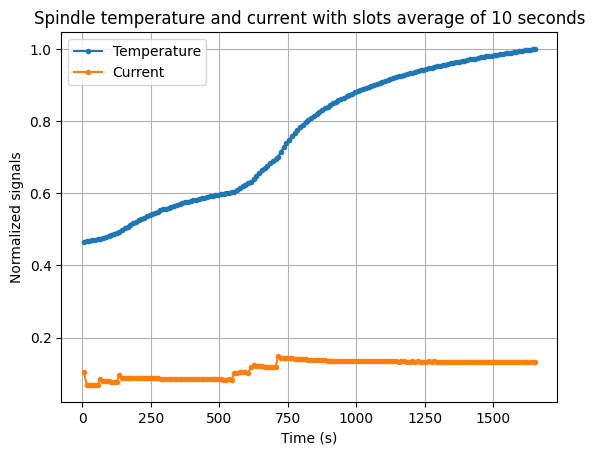

In [57]:
# apply the function to the temperature and current data
dt = 10 # seconds

temperatureSlots = computeSlotsAverage(temperatureData, dt)
currentSlots = computeSlotsAverage(currentData, dt)

# plot data versus time
plt.plot(
    temperatureSlots.loc[:, "timeSeconds"], temperatureSlots.loc[:, "value"], "o-", markersize=3)

plt.plot(
    currentSlots.loc[:, "timeSeconds"], currentSlots.loc[:, "value"], "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Normalized signals")
plt.legend(["Temperature", "Current"])
plt.title("Spindle temperature and current with slots average of " + str(dt) + " seconds")
plt.grid()
plt.show()

### Plot the current versus temperature

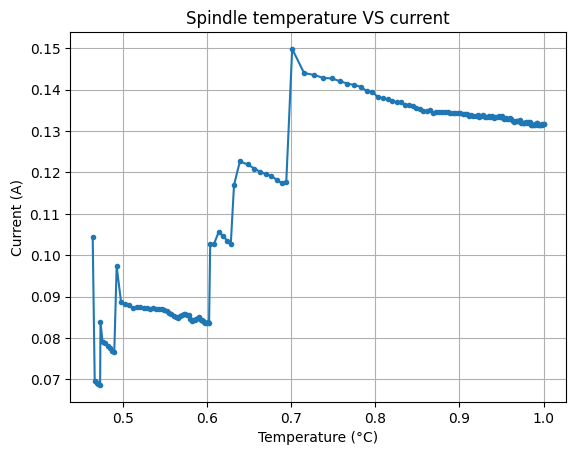

In [58]:
plt.plot(
    temperatureSlots.loc[:, "value"], currentSlots.loc[:, "value"], "-o", markersize=3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Current (A)")
plt.title("Spindle temperature VS current")
plt.grid()
plt.show()

## Test `getTemperatureCorrectionData` on various samples

We want to plot the current VS temperature plot for multiple samples.

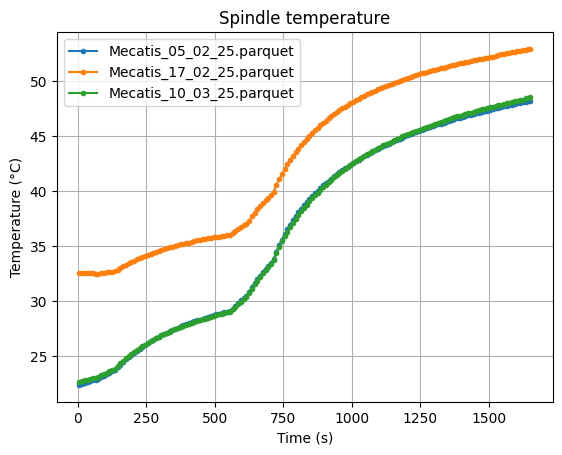

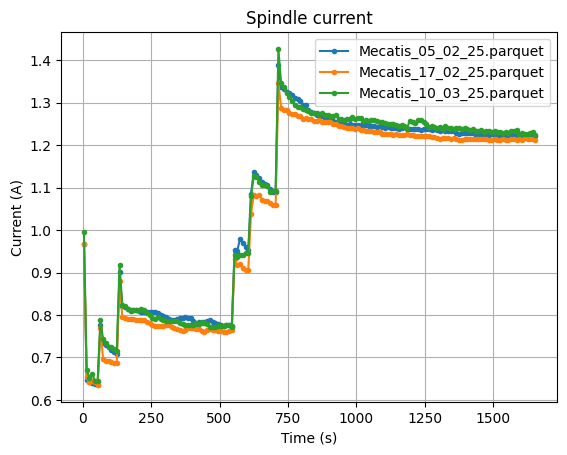

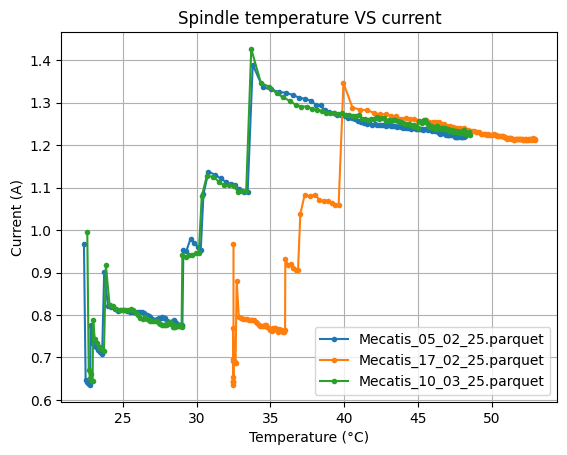

In [59]:
dataPath: Path = "../../data/normalized-2025_04_08/"

samples: list[Path] = ["Mecatis_05_02_25.parquet", "Mecatis_17_02_25.parquet", "Mecatis_10_03_25.parquet"] 

rawData = []
for sample in samples:
    path = os.path.join(dataPath, sample)
    currentData = pd.read_parquet(path)
    rawData.append(getTemperatureCorrectionData(currentData))

showTempCorrectionPlots(rawData, samples)

## Finding optimal temperature offset 

We want to minimize the distance between a temperature signal and a reference using just an offset.

In [60]:
offset1, error1 = findTemperatureOffset(rawData[1]["temperature"], rawData[0]["temperature"])

print("sample 1: ", samples[1])
print("Offset: ", offset1.round(2), "°C")
print("RMSE: ", error1.round(2), "°C")

offset2, error2 = findTemperatureOffset(rawData[2]["temperature"], rawData[0]["temperature"])
print("sample 2: ", samples[2])
print("Offset: ", offset2.round(2), "°C")
print("RMSE: ", error2.round(2), "°C")


sample 1:  Mecatis_17_02_25.parquet
Offset:  6.35 °C
RMSE:  1.47 °C
sample 2:  Mecatis_10_03_25.parquet
Offset:  0.04 °C
RMSE:  0.14 °C


### Plot the corrected data

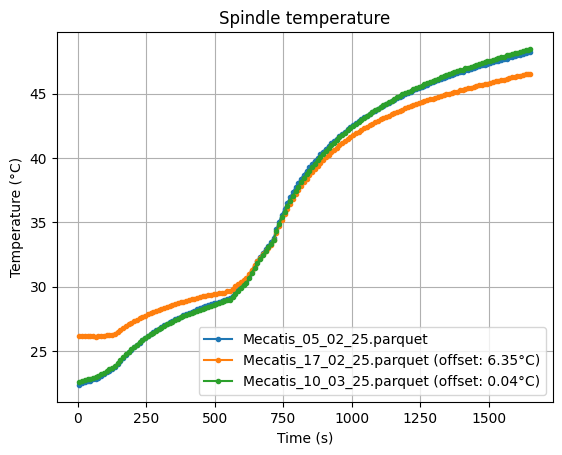

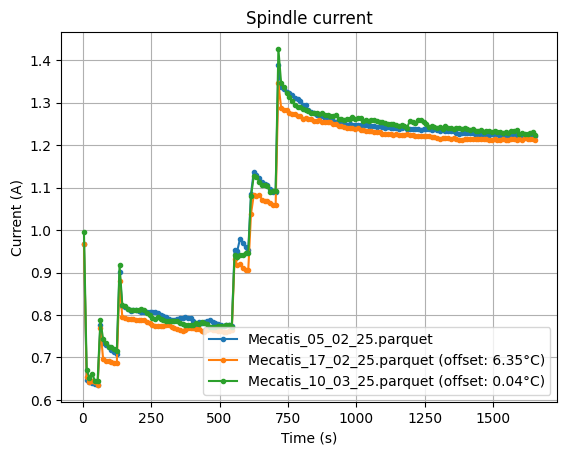

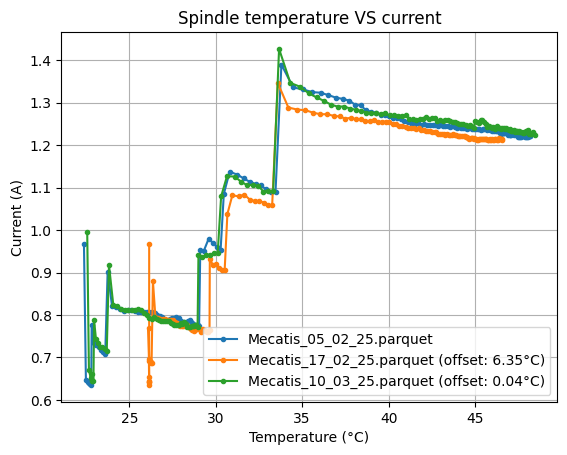

In [61]:
rawData[1]["temperature"] = rawData[1]["temperature"] - offset1
samples[1] = samples[1] + " (offset: " + str(offset1.round(2)) + "°C)"

rawData[2]["temperature"] = rawData[2]["temperature"] - offset2
samples[2] = samples[2] + " (offset: " + str(offset2.round(2)) + "°C)"

showTempCorrectionPlots(rawData, samples)

## Check if segments are the same in all samples

In [62]:

dataPath: Path = "../../data/normalized-2025_04_08/"

def getSampleSegmentIndices(samplePath: Path) -> list:
    """
    Get the sample segment indices.

    Parameters
    ----------
    samplePath (str): The path to the sample.

    Returns
    -------
    list: Indices of the sample segments.
    """
    data = pd.read_parquet(samplePath)
    time = data["timeSeconds"]
    command = data["stSigSpindleVelocity"]
    return detectConstantSegments(time, command)

indices1 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_05_02_25.parquet"))
print("Indices 1: ", indices1)
indices2 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_17_02_25.parquet"))
print("Indices 2: ", indices2)
indices3 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_10_03_25.parquet"))
print("Indices 3: ", indices3)


Indices 1:  [(893, 84083), (84959, 165527), (166403, 694810), (695686, 772705), (773581, 889295), (890171, 2065465)]
Indices 2:  [(893, 84072), (84948, 165512), (166388, 694795), (695670, 772677), (773552, 889265), (890141, 2065435)]
Indices 3:  [(892, 84083), (84958, 165521), (166396, 694796), (695672, 772690), (773566, 889276), (890151, 2065449)]


Remarks:
- different samples have different segment indices
- samples contains different number of points

## Split spindle current into segments
We want to split all the spindle current into segments and process each of the segments independently. First we need to find the start and end indices of the segments.

First, load a sample and put useful signals into some variables.

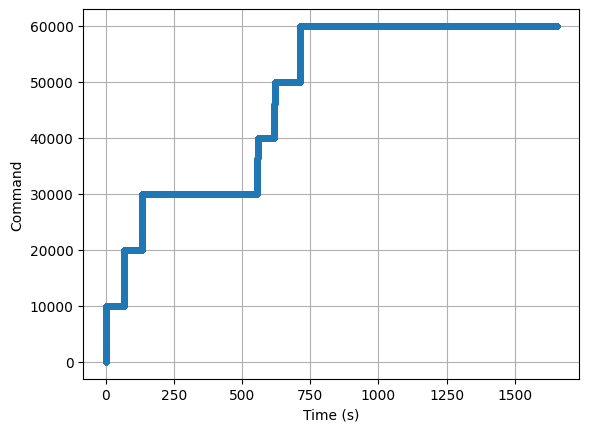

Operation indices:  [0, 81141, 162587, 691869, 769765, 886354]
Segment indices:  [(893, 84083), (84959, 165527), (166403, 694810), (695686, 772705), (773581, 889295), (890171, 2065465)]


In [63]:
dataPath: Path = "../../data/normalized-2025_04_08/"
samplePath = os.path.join(dataPath, "Mecatis_05_02_25.parquet")

rawData = pd.read_parquet(samplePath)
time = rawData["timeSeconds"]
command = rawData["stSigSpindleVelocity"]

plt.figure()
plt.plot(time, command, "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Command")
plt.grid()
plt.show()


operationsIndices = getOperationsStart(rawData["stSigOperation"])

print("Operation indices: ", operationsIndices)

segmentIndices = detectConstantSegments(time, command)
print("Segment indices: ", segmentIndices)

data = getTemperatureCorrectionData(rawData, timeSlot=None)


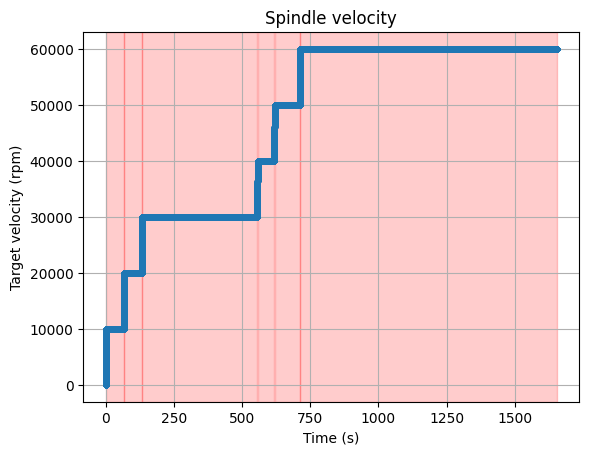

In [64]:
# plot the data
plt.figure()
plt.plot(time, command, "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Target velocity (rpm)")
plt.title("Spindle velocity")
plt.grid()
for segment in segmentIndices:
    plt.axvspan(time[segment[0]], time[segment[1]], color="red", alpha=0.2)
plt.show()

## Cut a signal into the segments and plot all the segments versus time

### Plot original spindle current

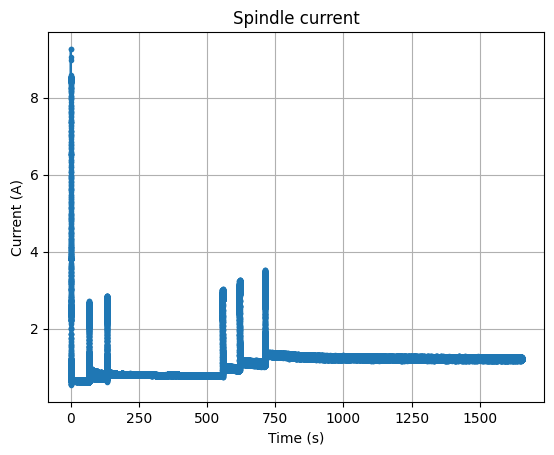

In [65]:
plt.figure()
plt.plot(time, data["current"], "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title("Spindle current")
plt.grid()
plt.show()

### Test plotting raw segments

<Figure size 640x480 with 0 Axes>

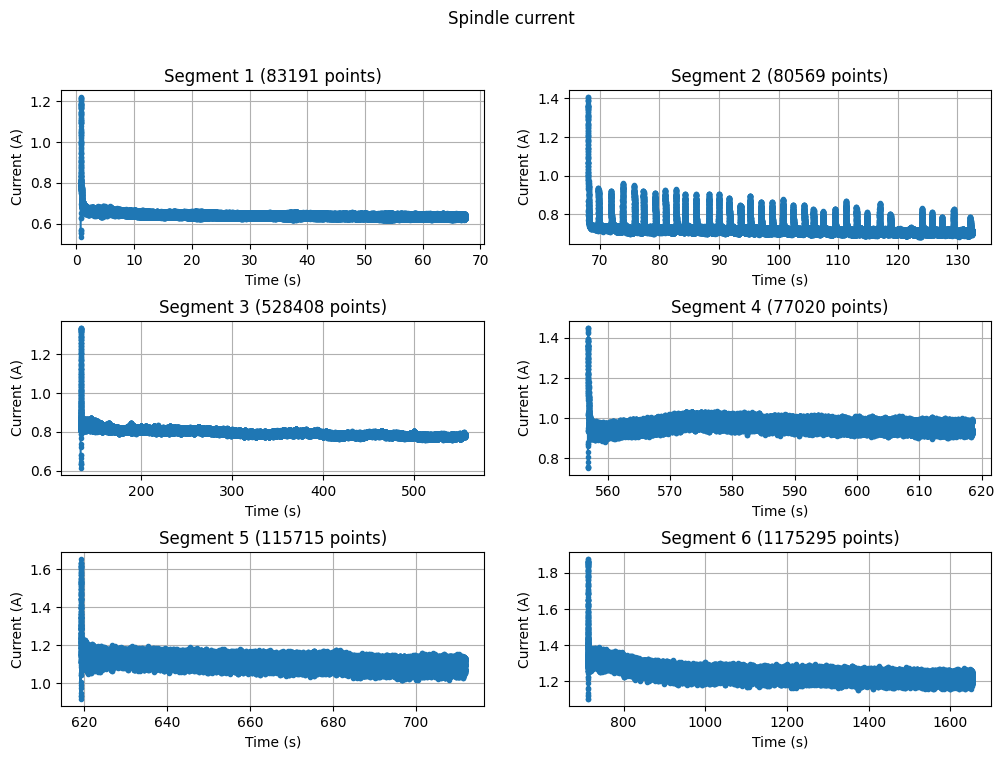

<Figure size 640x480 with 0 Axes>

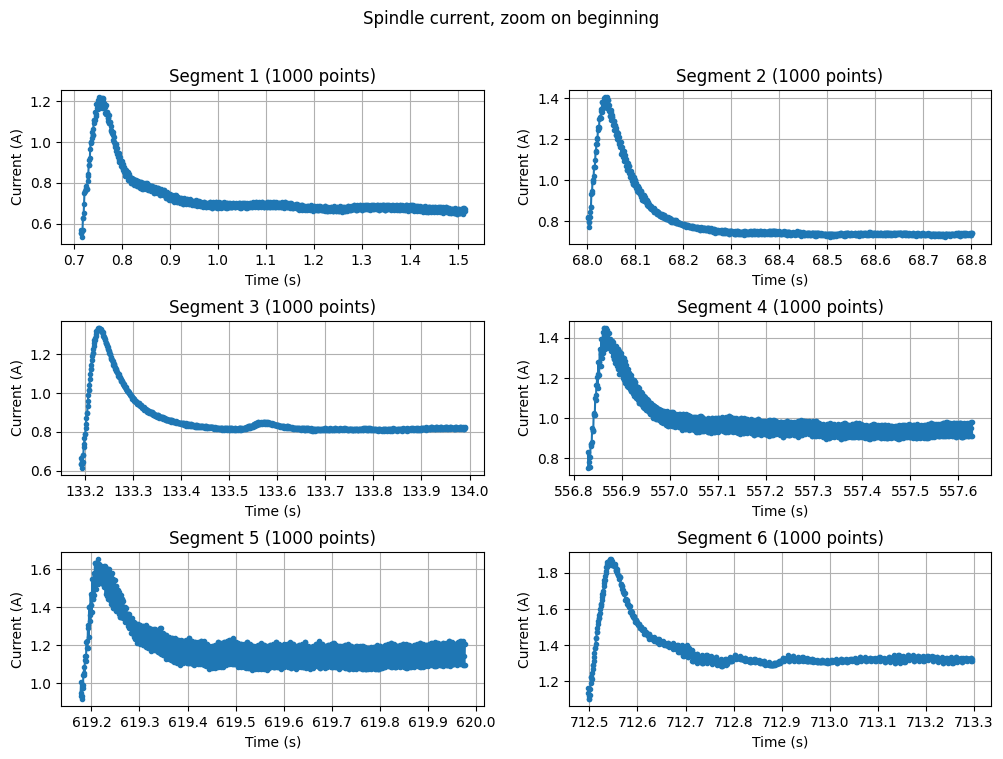

In [66]:
segments = splitSignal(data, segmentIndices)
plotSegments(segments)

# zoom in
plotSegments(segments, nbPoints=1000, title="Spindle current, zoom on beginning")

### Remove points at the beggining of segments

We want to remove the beginning of each segment in order to be in the stable state.

Frequency:  0.007024618759890664 Hz
Number of points to remove:  0


<Figure size 640x480 with 0 Axes>

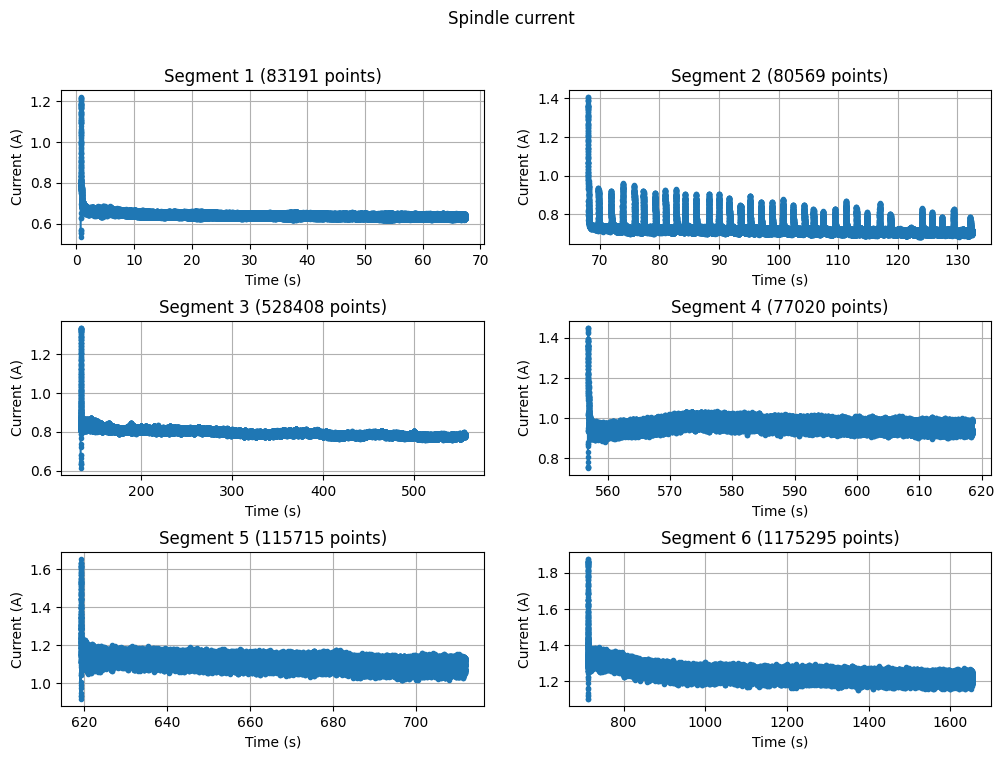

In [67]:
cutSegments = removeSegmentsBeginning(segments, timeToRemove=0.5, debug=True)
# plot the segments
plotSegments(cutSegments)

### Compute average by slots to reduce nb of points

<Figure size 640x480 with 0 Axes>

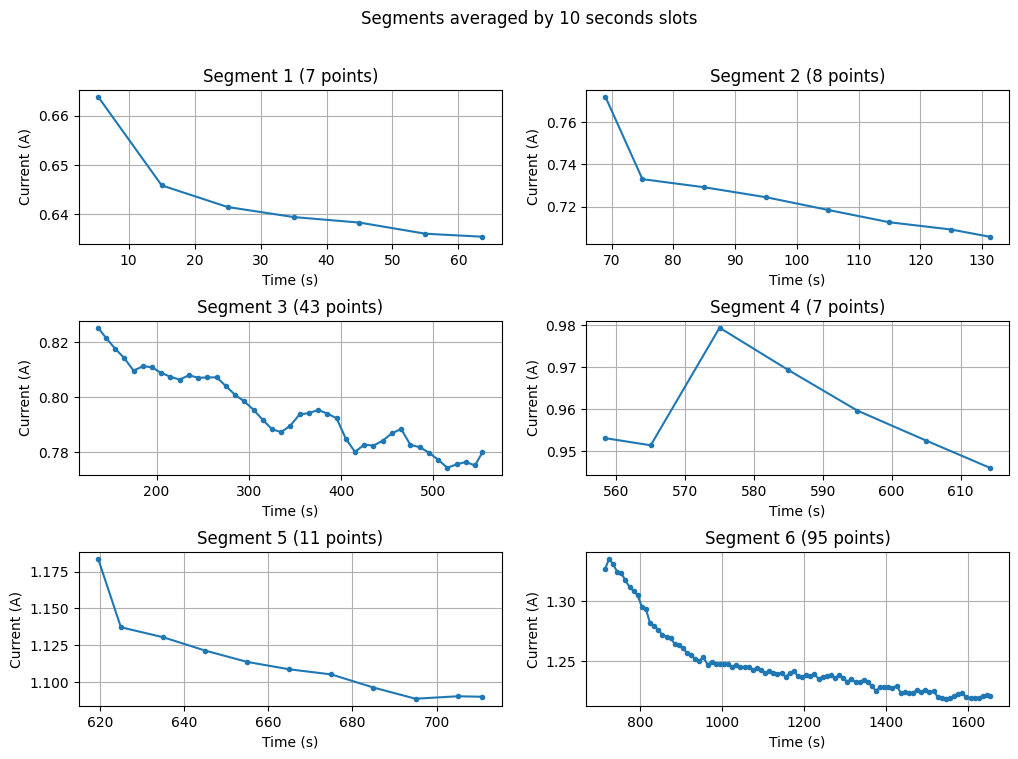

In [68]:
dt = 10 # seconds

averagedSegments = []

for i in range(len(cutSegments)):
    averagedSegments.append(computeSlotsAverage(cutSegments[i], dt))


# plot the segments
plotSegments(averagedSegments, title="Segments averaged by " + str(dt) + " seconds slots")

### Plot current versus temperature for each segment

<Figure size 640x480 with 0 Axes>

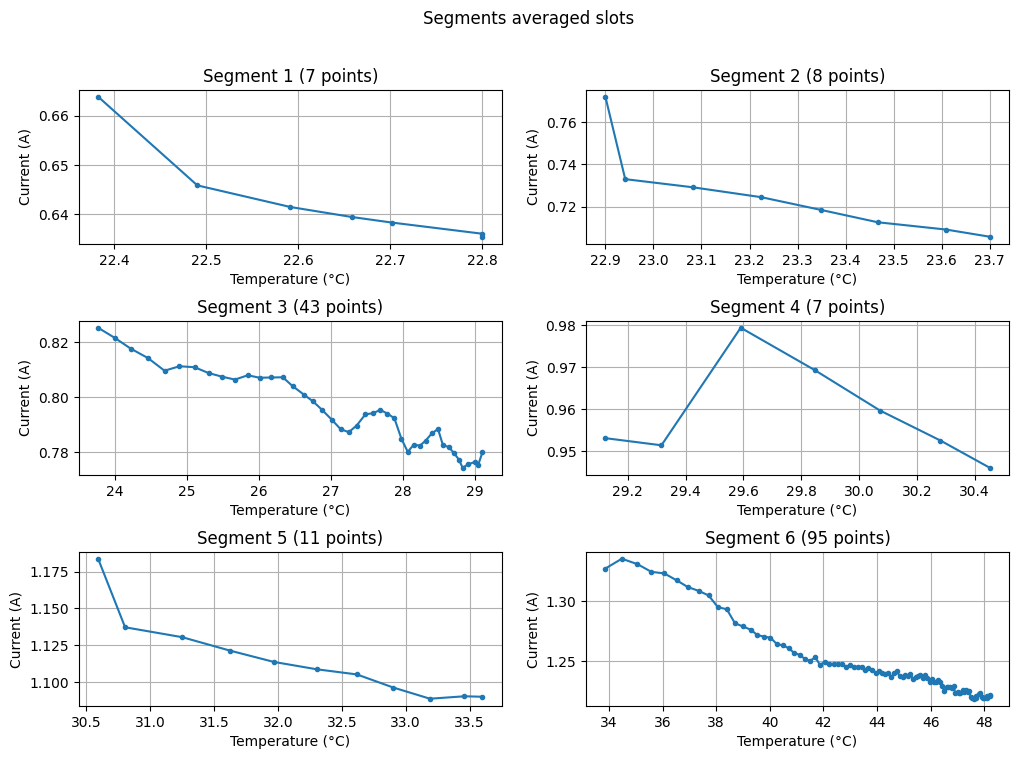

In [69]:
plotSegments(averagedSegments, xSignal= "temperature", ySignals=["current"], ylabel="Current (A)", xlabel="Temperature (°C)", title="Segments averaged slots")

## Compute regressions for each segment    

### Write functions


There is a bug somewhere and I struggled to find it.... In the end I just used the standard numpy functions...

 ### Test the functions

Parameters:  [ 1.75307013 -0.04426569]
RMSE:  0.0032640114781070377
Parameters:  [ 0.00909888  0.10655587 -0.0032602 ]
RMSE:  0.003381250076665538


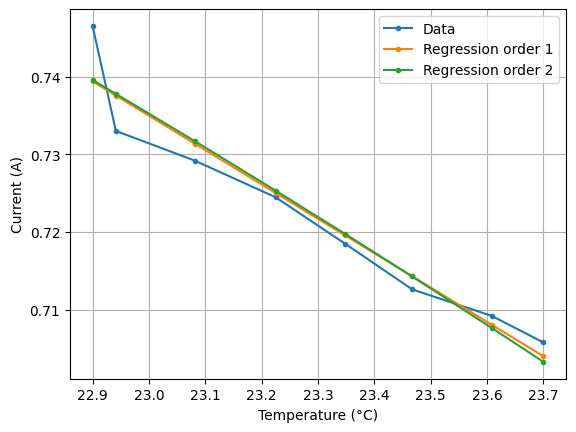

In [70]:
testData = pd.DataFrame()
testData["temperature"] = [1,2,5,6,9,10]
testData["current"] = [0.1,0.4,0.9,1.6,2.5,3.6]

realData = pd.DataFrame()
realData["temperature"] = [22.900000,  
                           22.941293,  
                           23.081673,  
                           23.224596,  
                           23.348171,  
                           23.466880,  
                           23.608718,  
                           23.700000]
  
realData["current"] = [0.746520,
                       0.733001,
                       0.729164,
                       0.724461,
                       0.718472,
                       0.712600,
                       0.709162,
                       0.705753]


# sort data by temperature
realData = realData.sort_values(by="temperature")


data = realData

reg1, err1 = getPolyRegression(data, order=1)
print("Parameters: ", reg1)
print("RMSE: ", err1)

model1 = evalPolyReg(reg1, data)

reg2, err2 = getPolyRegression(data, order=2)
print("Parameters: ", reg2)
print("RMSE: ", err2)

model2 = evalPolyReg(reg2, data)

plt.figure()
plt.plot(data["temperature"], data["current"], "o-", markersize=3)
plt.plot(data["temperature"], model1, "o-", markersize=3)
plt.plot(data["temperature"], model2, "o-", markersize=3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Current (A)")
plt.legend(["Data", "Regression order 1", "Regression order 2"])
plt.grid()
plt.show()

### Compute regressions on real data

In [71]:


models = getPolyFits(averagedSegments, order=3)
segments = evalModels(averagedSegments, models)
errors = getRelativeErrors(segments)
print("Errors: ", errors)

   
plotSegments(segments, xSignal= "temperature", ySignals=["current", "polyFit"],
             ylabel="Current (A)", xlabel="Temperature (°C)",
             title="Spindle current versus temperature with polynomial fit",
             legend=["Measurements", "Polynomial fit"])


TypeError: 'module' object is not callable

### Final temperature correction function

We consider the variation of the current depending on the temperature as a bias. In order to remove it, we subtract the regression data from the current data.

## Test the whole temperature correction

In [ ]:
import time as timeLib

dataPath: Path = "../../data/normalized-2025_04_08/"

samplePath = os.path.join(dataPath, "Mecatis_17_02_25.parquet")

rawData = pd.read_parquet(samplePath)
time = rawData["timeSeconds"]
command = rawData["stSigSpindleVelocity"]
startTime = timeLib.time()
segmentIndices = detectConstantSegments(time, command)
endTime = timeLib.time()
print("Time to find constant segments: ", endTime - startTime)
data = getTemperatureCorrectionData(rawData, timeSlot=None)

Time to find constant segments:  7.044787883758545


Frequency:  1250.0 Hz
Number of points to remove:  625
Relative error in percents for each segment: 
0    31.0
1     4.0
2     6.0
3     9.0
4     8.0
5     3.0
dtype: float64
Correction indices:  [[0, 84072], [84073, 165512], [165513, 694795], [694796, 772677], [772678, 889265], [889266, 2065435]]
Initial current:  0.6463176203251306
Initial current:  0.7128980493434938
Initial current:  0.7943817104031723
Initial current:  0.9165324561154193
Initial current:  1.0807890846402302
Initial current:  1.2799105640496542
Corrected current dimensions:  (2065436,)


/var/folders/yw/_xsq4q0n0bd5yqsbz7rwv67h0000gp/T/ipykernel_63577/2473138398.py:11: RankWarning: Polyfit may be poorly conditioned
  model = np.poly1d(np.polyfit(segment["temperature"], segment["current"], order))


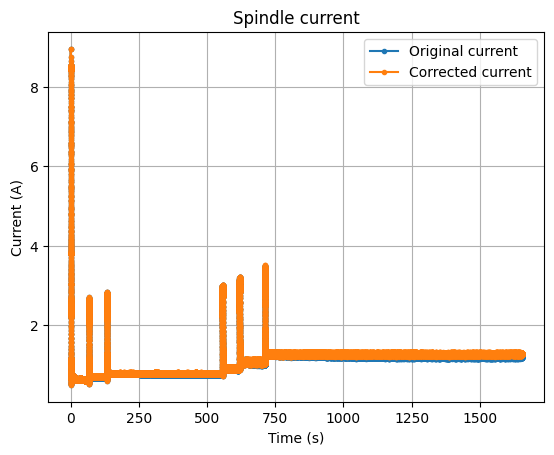

In [ ]:

correctedCurrent = temperatureCorrection(data, segmentIndices, debug=True)

# plot the original and corrected current
plt.figure()
plt.plot(data["timeSeconds"], data["current"], "o-", markersize=3)
plt.plot(data["timeSeconds"], correctedCurrent, "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.legend(["Original current", "Corrected current"])
plt.title("Spindle current")
plt.grid()

# plt.xlim([554, 560])
# plt.ylim([0,4])
plt.show()